# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

- The data represents 17 campaigns which were done during May 2008 until Nov 2010, during those campaigns 76354 Contacts were made, having 6499 subscribed.


### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.pipeline import Pipeline

import category_encoders as ce
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.inspection import permutation_importance

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.dummy import DummyClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, f1_score, PrecisionRecallDisplay, auc as skcauc, precision_recall_curve, roc_curve, RocCurveDisplay

import plotly.express as px
import warnings
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [45]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [46]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Missing values review

In [48]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

#### There are no missing values

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

Predict if the client will subcribe a bank term deposit by running classification algorithms over the feature "y", where "yes" means the client will subcribe and "no" the client will not subcribe.

#### Review the subscribed proportion

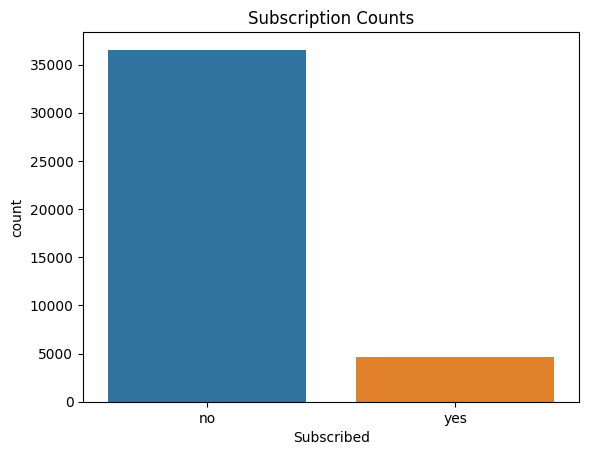

In [49]:
sns.countplot(data = df, x = df["y"]).set_title("Subscription Counts")
plt.xlabel('Subscribed')
plt.show()

#### This is an imbalanced dataset

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

#### Identifying the categorical values

In [50]:
def get_feature_unique_values(values_df, only_string):
    colList = values_df.dtypes.reset_index()
    # get the features with object type
    cols = colList
    if(only_string):
        cols = colList[colList[0] == 'object']
        
    col_unique_val_counter = []
    for colname in cols["index"]:
        col_unique_vals = values_df[colname].unique()
        print("--------------")
        print(colname, ", total unique values: ", len(col_unique_vals))
        print("--------------")    
        print(col_unique_vals)
        col_unique_val_counter.append([colname, len(col_unique_vals)])

    # show a sorted df with the unique values counting
    print(" ")
    print("----------------------------------------")
    print("--------Unique Values Summary-----------")
    print(pd.DataFrame(col_unique_val_counter, columns =["Feature", "Total"]).sort_values(by='Total', ascending=False))


In [51]:
# Create a DF with just bank information features and the target
# (section # bank client data: in the feature descriptions above) columns 1 to 7.
bankinfo_df = df[["age", "job", "marital", "education", "default", "housing", "loan", "y"]]


In [52]:
get_feature_unique_values(bankinfo_df, True)

--------------
job , total unique values:  12
--------------
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
--------------
marital , total unique values:  4
--------------
['married' 'single' 'divorced' 'unknown']
--------------
education , total unique values:  8
--------------
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
--------------
default , total unique values:  3
--------------
['no' 'unknown' 'yes']
--------------
housing , total unique values:  3
--------------
['no' 'yes' 'unknown']
--------------
loan , total unique values:  3
--------------
['no' 'yes' 'unknown']
--------------
y , total unique values:  2
--------------
['no' 'yes']
 
----------------------------------------
--------Unique Values Summary-----------
     Feature  Total
0        job     12
2  education      8
1    marital      4
3    defa

In [53]:
# Using OrdinalEncoder to encode all the categorical features
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan']
bankinfo_df_enc = ce.OrdinalEncoder(cols = cat_features).fit_transform(bankinfo_df)
bankinfo_df_enc



# Rename target feature
bankinfo_df_enc.rename({"y" : "subscribed"}, axis = 1, inplace = True)
bankinfo_df_enc["subscribed"].replace({"no" : 0, "yes" : 1}, inplace = True)


In [54]:
bankinfo_df_enc

,age,job,marital,education,default,housing,loan,subscribed
0,56,1,1,1,1,1,1,0
1,57,2,1,2,2,1,1,0
2,37,2,1,2,1,2,1,0
3,40,3,1,3,1,1,1,0
4,56,2,1,2,1,1,2,0
...,...,...,...,...,...,...,...,...
41183,73,6,1,5,1,2,1,1
41184,46,4,1,5,1,1,1,0
41185,56,6,1,7,1,2,1,0
41186,44,5,1,5,1,1,1,1


### Reviewing the correlation for the bank information features (columns 1 to 7 of the original Dataset)


In [55]:
correlation_data = bankinfo_df_enc.corr()

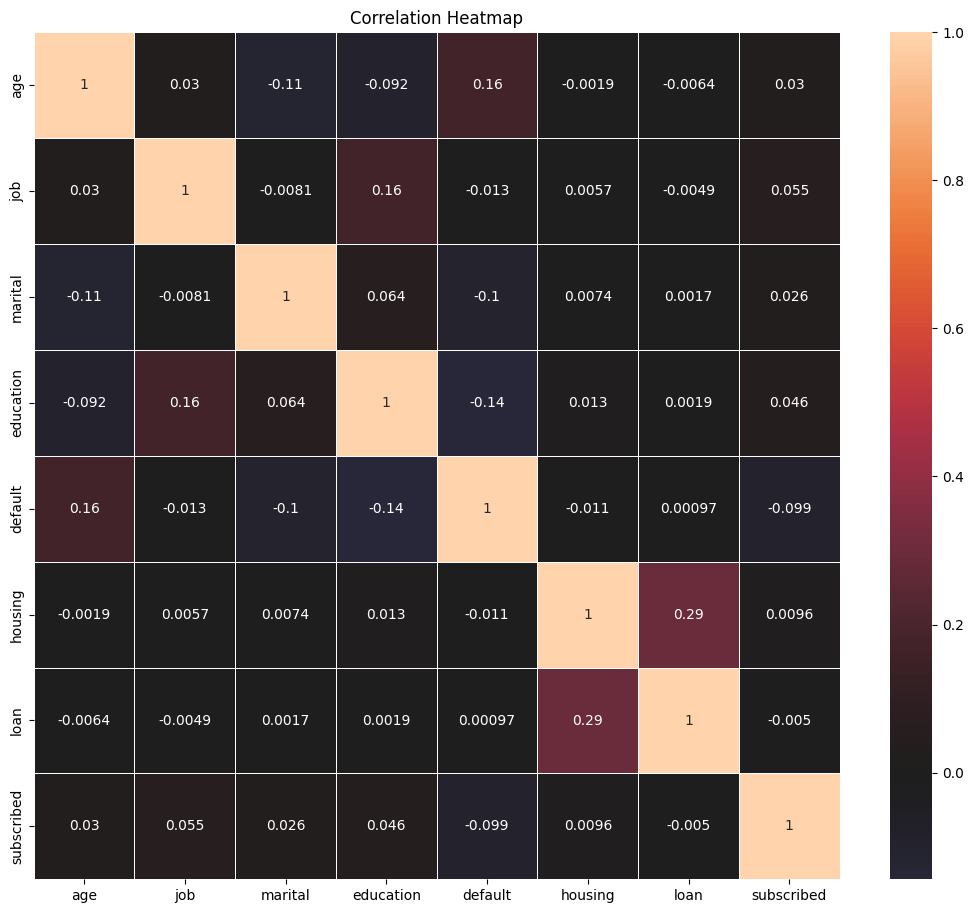

In [56]:
#correlation heatmap  
sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(13, 11))

sns.heatmap(correlation_data, center = 0, linewidth = .5, annot = True).set(title='Correlation Heatmap');

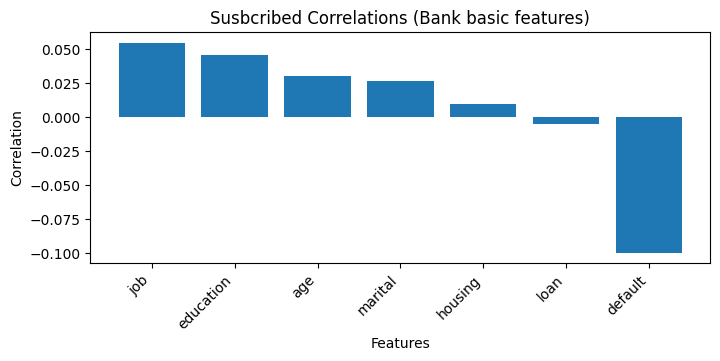

In [57]:
corr_df_7feat = correlation_data[['subscribed']].sort_values(by='subscribed', ascending=False)[1:].reset_index()
corr_df_7feat.rename(columns={"index": "feature"}, inplace=True)


plt.figure(figsize=(8,3))
plt.bar(x=corr_df_7feat["feature"], height=corr_df_7feat["subscribed"], label='line 1')
plt.title("Susbcribed Correlations (Bank basic features)")
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45, ha='right')
plt.show()



#### The most positive correlated feature with the target are : 
- job
- education
- age
- marital
- housing
#### The negative correlated feature with the target are : 
- loan
- default

### Using and LogisticRegressor to select the features

In [18]:
#SequentialFeatureSelection
sfs = SequentialFeatureSelector(estimator = LogisticRegression(),
                               scoring = "accuracy",
                               cv = 5,
                               n_features_to_select = 'auto')

sfs.fit(bankinfo_df_enc.drop('subscribed', axis = 1), bankinfo_df_enc['subscribed'])

SequentialFeatureSelector(estimator=LogisticRegression(),
                          n_features_to_select='auto', scoring='accuracy')

In [19]:
#getting results
sfs.get_feature_names_out(input_features=None)

array(['age', 'job', 'marital'], dtype=object)

#### The SequentialFeatureSelector selected :
- age
- job
- marital



### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [20]:
X = bankinfo_df_enc.drop('subscribed', axis = 1)
y = bankinfo_df_enc['subscribed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [21]:
# Use the DummyClassifier
dummy = DummyClassifier(strategy= "prior")

# fit the mdel 
dummy.fit(X_train, y_train)

# accuracy score
print("The accuracy of the dummy classifier for train is {:.2%}".format(dummy.score(X_train, y_train)))
print("The accuracy of the dummy classifier for test is {:.2%}".format(dummy.score(X_test, y_test)))

The accuracy of the dummy classifier for train is 88.72%
The accuracy of the dummy classifier for test is 88.76%


In [22]:
# Create a list and function to save the results
results_list = []
def save_result(model, train_time, train_accuracy, test_accuracy):
    '''
    Save model results in a array
    '''
    results_list.append({
        'Model': model,
        'Train Time': train_time,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy
    })

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [23]:
start_time = time.time()
log_r = LogisticRegression(max_iter=2000).fit(X_train, y_train)
train_time = time.time() - start_time

### Problem 9: Score the Model

What is the accuracy of your model?

In [24]:
y_train_pred = log_r.predict(X_train)
y_test_pred = log_r.predict(X_test)

In [25]:
print("Accuracy_score the logistic regressor for train is {:.2%}".format(accuracy_score(y_train_pred, y_train)))
print("Accuracy_score the logistic regressor for test is {:.2%}".format(accuracy_score(y_test_pred, y_test)))

Accuracy_score the logistic regressor for train is 88.72%
Accuracy_score the logistic regressor for test is 88.76%


In [26]:
ps = precision_score(y_test, y_test_pred, zero_division=0)
rc = recall_score(y_test, y_test_pred)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)


In [27]:
print(f'Precision: {ps}')
print(f'Recall: {rc}')
print(f'Accuracy: {test_acc}')
print(f'F1: {f1}')

Precision: 0.0
Recall: 0.0
Accuracy: 0.8875940762320952
F1: 0.0


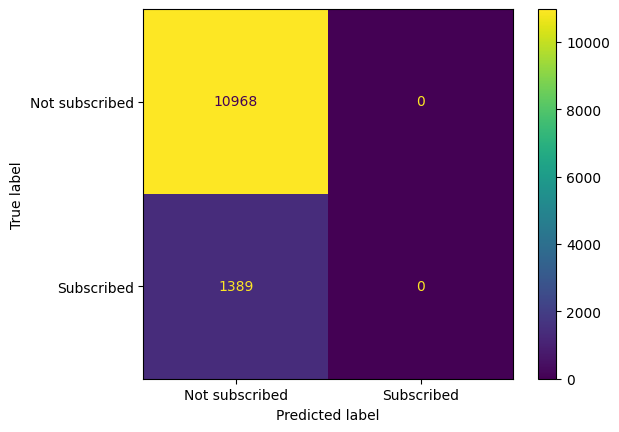

In [28]:
confusion_mat = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['Not subscribed', 'Subscribed' ])
disp.plot()
plt.show()

In [29]:
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10968
           1       0.00      0.00      0.00      1389

    accuracy                           0.89     12357
   macro avg       0.44      0.50      0.47     12357
weighted avg       0.79      0.89      0.83     12357



In [30]:
# save the Logistic Regression's result 
save_result('LogisticRegression', train_time, train_acc, test_acc)

In [31]:
results_list[0]

{'Model': 'LogisticRegression',
 'Train Time': 0.2315678596496582,
 'Train Accuracy': 0.8872394297804447,
 'Test Accuracy': 0.8875940762320952}

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

#### KNN Simple Model Execution

In [32]:
# Fit and training
start_time = time.time()
knn = KNeighborsClassifier().fit(X_train, y_train)
train_time = time.time() - start_time

In [33]:
# Predict
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

In [34]:
ps = precision_score(y_test, y_test_pred, zero_division=0)
rc = recall_score(y_test, y_test_pred)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

In [35]:
print(f'Precision: {ps}')
print(f'Recall: {rc}')
print(f'Accuracy: {test_acc}')
print(f'F1: {f1}')

Precision: 0.3231939163498099
Recall: 0.061195104391648665
Accuracy: 0.8800679776644816
F1: 0.10290556900726391


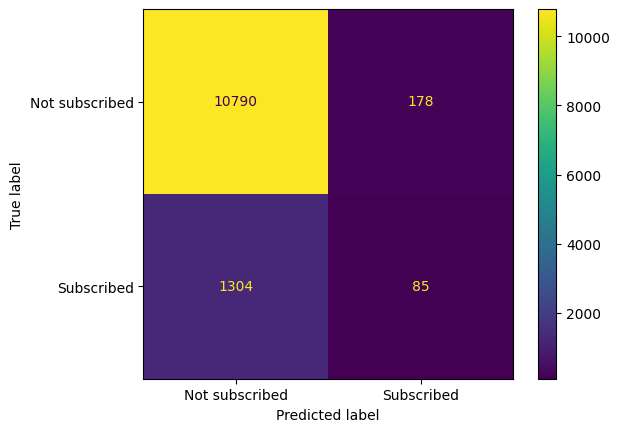

In [36]:
confusion_mat = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['Not subscribed', 'Subscribed' ])
disp.plot()
plt.show()

In [37]:
# save the KNeighborsClassifier's result 
save_result('KNeighborsClassifier', train_time, train_acc, test_acc)
results_list[1]

{'Model': 'KNeighborsClassifier',
 'Train Time': 0.01752924919128418,
 'Train Accuracy': 0.8907772883354722,
 'Test Accuracy': 0.8800679776644816}

#### Decision Tree Simple Model Execution

In [38]:
# Fit and training
start_time = time.time()
dtree = DecisionTreeClassifier().fit(X_train, y_train)
train_time = time.time() - start_time

In [39]:
# Predict
y_train_pred = dtree.predict(X_train)
y_test_pred = dtree.predict(X_test)

In [40]:
ps = precision_score(y_test, y_test_pred, zero_division=0)
rc = recall_score(y_test, y_test_pred)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

In [41]:
print(f'Precision: {ps}')
print(f'Recall: {rc}')
print(f'Accuracy: {test_acc}')
print(f'F1: {f1}')

Precision: 0.22123893805309736
Recall: 0.08999280057595392
Accuracy: 0.8621024520514688
F1: 0.12794268167860798


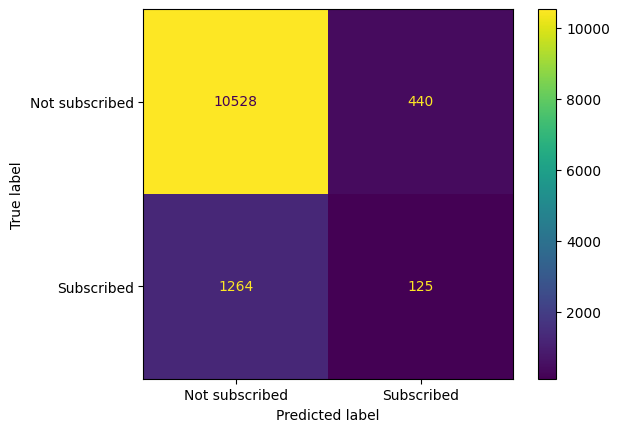

In [42]:
confusion_mat = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['Not subscribed', 'Subscribed' ])
disp.plot()
plt.show()

In [43]:
# save the DecisionTreeClassifier's result 
save_result('DecisionTreeClassifier', train_time, train_acc, test_acc)
results_list[2]

{'Model': 'DecisionTreeClassifier',
 'Train Time': 0.0497891902923584,
 'Train Accuracy': 0.9179702403662724,
 'Test Accuracy': 0.8621024520514688}

#### SVM Simple Model Execution

In [44]:
start_time = time.time()
svc = SVC().fit(X_train, y_train)
train_time = time.time() - start_time

In [45]:
# Predict
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

In [46]:
ps = precision_score(y_test, y_test_pred, zero_division=0)
rc = recall_score(y_test, y_test_pred)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

In [47]:
print(f'Precision: {ps}')
print(f'Recall: {rc}')
print(f'Accuracy: {test_acc}')
print(f'F1: {f1}')

Precision: 0.0
Recall: 0.0
Accuracy: 0.8875940762320952
F1: 0.0


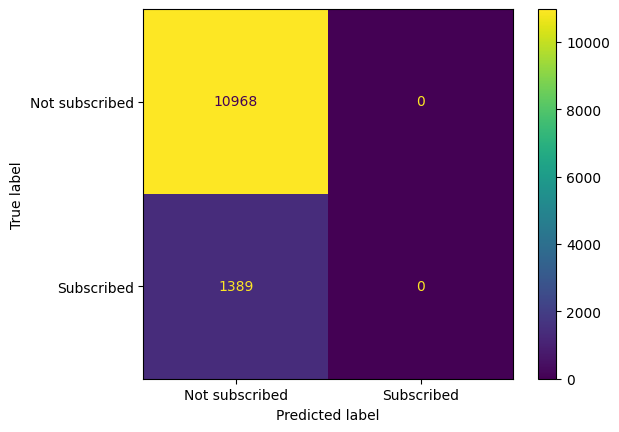

In [48]:
confusion_mat = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['Not subscribed', 'Subscribed' ])
disp.plot()
plt.show()

In [49]:
# save the SVM's result 
save_result('SVM', train_time, train_acc, test_acc)
results_list[3]

{'Model': 'SVM',
 'Train Time': 3.106519937515259,
 'Train Accuracy': 0.8872394297804447,
 'Test Accuracy': 0.8875940762320952}

In [ ]:
results_df = pd.DataFrame(results_list).set_index('Model').sort_values(by='Test Accuracy', ascending=False)
results_df

,Train Time,Train Accuracy,Test Accuracy
Model,,,
LogisticRegression,0.231568,0.887239,0.887594
SVM,3.106520,0.887239,0.887594
KNeighborsClassifier,0.017529,0.890777,0.880068
DecisionTreeClassifier,0.049789,0.917970,0.862102


#### Findings 
The above results of this basic dataset(first 7 features ) and basic models show us:
- In terms of Training time the Logisitic Regression is the best
- In terms of Test Accuracy the Logisitic Regression is the best along with the SVM, but this one took more training time.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

For improving the results:
- Create a new Dataframe including more features (the previous results were gotten using the basic Bank Client Data only).
- Identify which features to include by:
    - Feature description: there are some which must not included
        - duration: the dataset's description mentions to discard this one.
    - Feature selection.
- Run correlation with more features
- Run GridSearch to identify the best model and parameters
- Add more metrics: F1, Precision and Recall
- Evaluate the Lift Curve: this was mentioned by the DataSet Authors as the most suitable curve for Marketing Campaigns Data


In [58]:
# Rename the target as 'subscribed'
df = df.rename(columns={"y": "subscribed"})
# Replace its yes/no values to 1/0
df['subscribed'] = np.where(df['subscribed'] == 'yes', 1, 0)

[Text(0.5, 1.0, 'Features Correlation')]

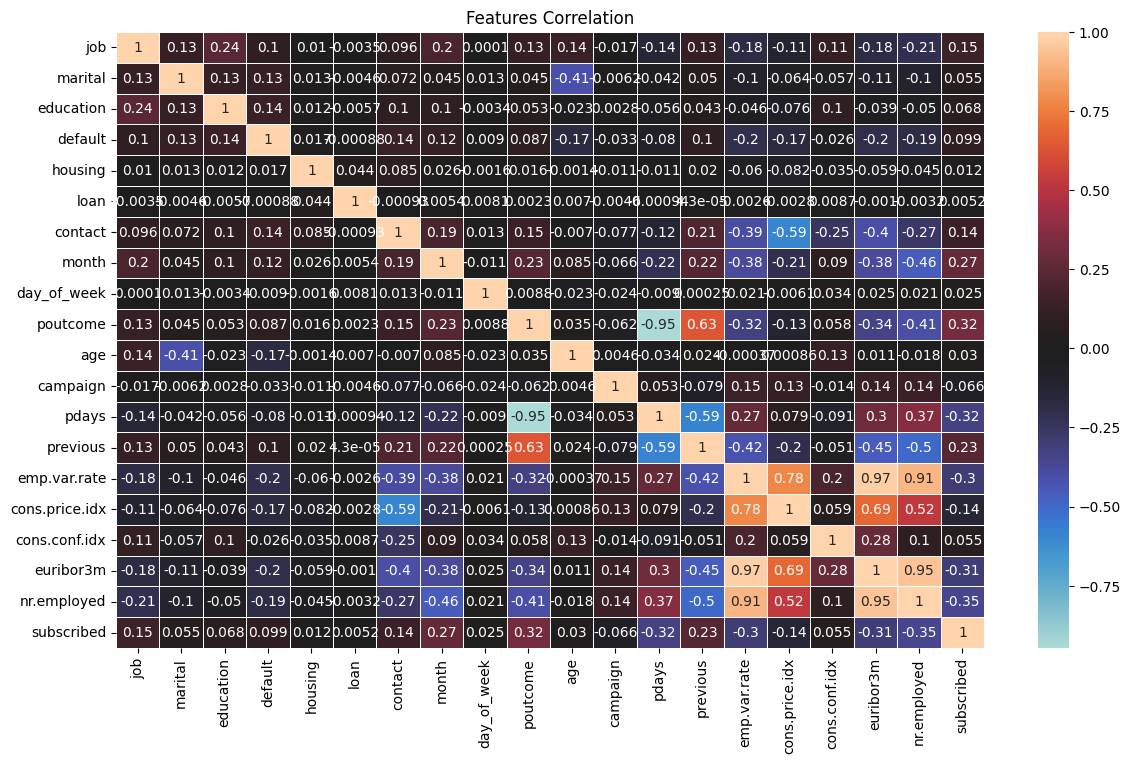

In [59]:
# Create a new Dataframe with more features and applying the TargetEncoder for the categorical
# Categorical features: I'll use the 
cats = ['job' , 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
trg_enc = ce.TargetEncoder()
new_bank_info = pd.concat([trg_enc.fit_transform(df[cats] , df["subscribed"]), 
                          df[['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'subscribed']
                       ]], axis = 1)

# Run the correlation 
corr_data = new_bank_info.corr()

sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(corr_data, center = 0, linewidth = .5, annot = True).set(title='Features Correlation')

- There are several characteristics with a high correlation between them ('emp.var.rate', 'cons.price.idx', 'nr.employed'), these will removed to get the final dataframe

[Text(0.5, 1.0, 'Features Correlation')]

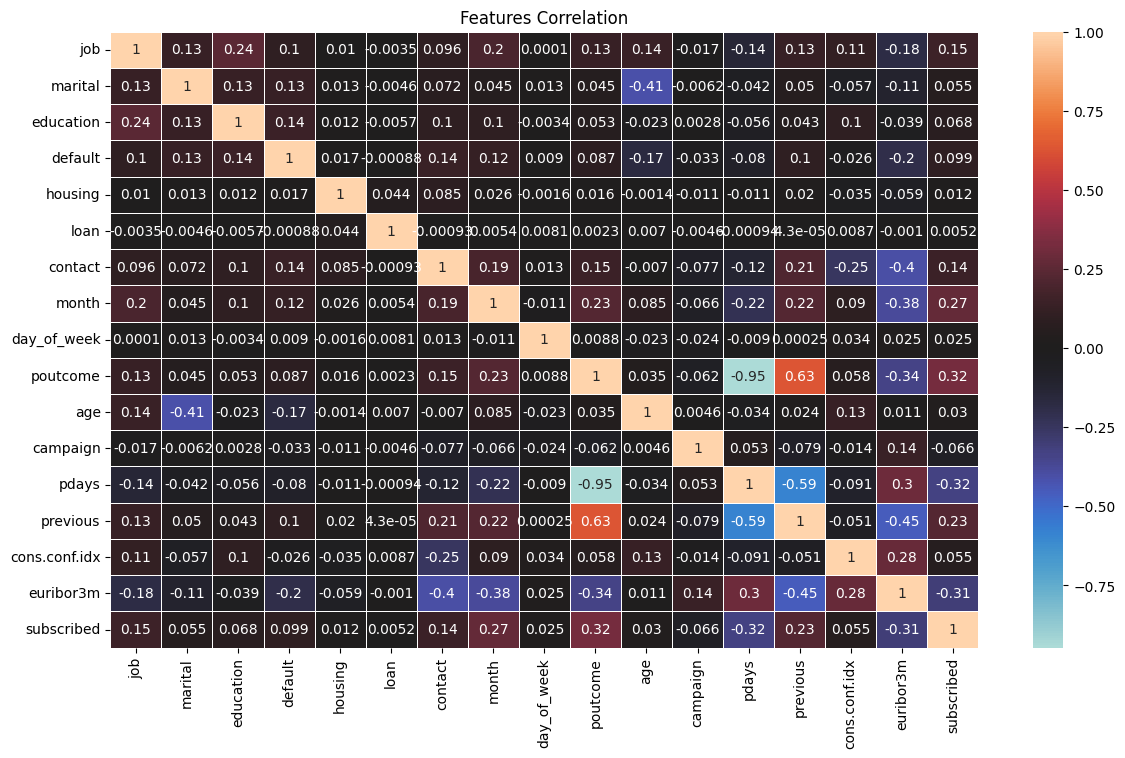

In [60]:
cats = ['job' , 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
trg_enc = ce.TargetEncoder()
final_bank_info = pd.concat([trg_enc.fit_transform(df[cats] , df["subscribed"]), 
                          df[['age', 'campaign', 'pdays', 'previous', 'cons.conf.idx', 'euribor3m','subscribed']
                       ]], axis = 1)

# Run the correlation 
corr_data = final_bank_info.corr()

sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(corr_data, center = 0, linewidth = .5, annot = True).set(title='Features Correlation')

In [61]:
# Create the Train and Test data
X = final_bank_info.drop('subscribed', axis = 1)
y = final_bank_info['subscribed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,age,campaign,pdays,previous,cons.conf.idx,euribor3m
39075,0.129726,0.101573,0.137245,0.12879,0.108796,0.113402,0.147376,0.489011,0.099483,0.142286,29,3,999,1,-33.0,0.709
34855,0.108260,0.140041,0.137245,0.12879,0.108796,0.113402,0.052313,0.064347,0.108087,0.088322,29,4,999,0,-46.2,1.250
7107,0.068943,0.101573,0.082024,0.05153,0.116194,0.113402,0.052313,0.064347,0.121188,0.088322,45,2,999,0,-36.4,4.860
31614,0.081381,0.101573,0.137245,0.12879,0.108796,0.113402,0.147376,0.064347,0.121188,0.142286,34,1,999,1,-46.2,1.327
34878,0.129726,0.140041,0.108355,0.12879,0.108796,0.113402,0.147376,0.064347,0.108087,0.088322,32,9,999,0,-46.2,1.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0.252326,0.101573,0.113485,0.05153,0.108796,0.113402,0.052313,0.064347,0.117800,0.088322,58,2,999,0,-36.4,4.857
11284,0.112175,0.101573,0.137245,0.12879,0.108796,0.113402,0.052313,0.105115,0.121188,0.088322,37,1,999,0,-41.8,4.961
38158,0.129726,0.101573,0.108355,0.12879,0.116194,0.113402,0.147376,0.438719,0.121188,0.651129,35,1,4,1,-26.9,0.754
860,0.112175,0.101573,0.137245,0.12879,0.116194,0.113402,0.052313,0.064347,0.116671,0.088322,40,2,999,0,-36.4,4.856


##### Helper functions

In [62]:
def get_training_time_from_grid(grid):
    '''
    Get the Fit training time from the gridsearch.cv_results
    '''
    # get the mean fit time
    mean_fit_time= grid.cv_results_['mean_fit_time']
    #mean_score_time= search_cv.cv_results_['mean_score_time']
    #number of splits of training data
    n_splits  = grid.n_splits_ 
    #Iterations per split
    n_iter = pd.DataFrame(grid.cv_results_).shape[0] 
     #print(np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter)
    return np.mean(mean_fit_time) * n_splits * n_iter    

In [63]:
results_list2 = []
def save_result_2(model, train_time, accuracy, f1, recall, precision):
    '''
    Save model results in a array
    '''
    results_list2.append({
        'Model': model,
        'Train Time': train_time,
        'Accuracy': accuracy,
        'f1': f1, 
        'recall': recall, 
        'precision': precision
    })

In [64]:
def getConfusionMatrix(y_test, y_test_pred, display_labels):
    '''
    Get the confusion matrix for the provided data
    '''
    confusion_mat = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=display_labels)
    disp.plot()
    plt.show()

In [65]:
def getScores(y_test, y_test_pred):
    '''
    Get the scores
    '''
    ps = precision_score(y_test, y_test_pred)
    rc = recall_score(y_test, y_test_pred)
    acc = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    scores = pd.DataFrame({'Scores':['Precision', 'Recall', 'Accuracy', 'F1'], 'Values' : [ps, rc, acc, f1]})
    display(scores)
    sns.barplot(scores, x = 'Scores', y = 'Values')
    return (ps, rc, acc, f1)

In [66]:
def plot_lift_curve(y_val, y_pred, step=0.01):
    '''
    Plot the Lift Curve
    '''
    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    
    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []
    
    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number 
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
           
   #Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    axis.grid()
    plt.title('Lift Curve')
    plt.show()

In [67]:
def getCurves(X_test, estimator):
    '''
    plot the ROC Curves
    '''
    test_predictions = estimator.predict_proba(X_test)
    y_lb_test = np.where(y_test == 1, 'Subscribed', 'Not subscribed')
    ig, ax = plt.subplots(1, 2)
    #fig.set_size_inches(12, 12)
    
    fpr, tpr, thresh_rocs = roc_curve(y_lb_test, test_predictions[:, 1], pos_label='Subscribed')
    roc_auc_value = skcauc(fpr, tpr)
    roc_plt = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
    roc_plt.plot(ax=ax[0])
    ax[0].grid()
    precision, recall, boundaries = precision_recall_curve(y_lb_test, test_predictions[:, 1], pos_label='Subscribed')
    pre_rec_plot = PrecisionRecallDisplay(precision=precision, recall=recall)
    pre_rec_plot.plot(ax=ax[1])
    ax[1].grid()    

    plot_lift_curve(y_test, y_test_pred)

#### Running KNN, LogisticRegression, DecisionTree and SVM using the dataframe with more features, GridSearch and Hyperparameters 


In [68]:
# Get the train and test data
# Exclude the features we identified to be removed
X = df.drop(['subscribed', 'emp.var.rate', 'cons.price.idx', 'nr.employed', 'duration'], axis = 1)
y = df['subscribed']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,cons.conf.idx,euribor3m
39075,29,admin.,married,university.degree,no,no,no,cellular,dec,mon,3,999,1,failure,-33.0,0.709
34855,29,technician,single,university.degree,no,no,no,telephone,may,fri,4,999,0,nonexistent,-46.2,1.250
7107,45,blue-collar,married,basic.6y,unknown,yes,no,telephone,may,thu,2,999,0,nonexistent,-36.4,4.860
31614,34,services,married,university.degree,no,no,no,cellular,may,thu,1,999,1,failure,-46.2,1.327
34878,32,admin.,single,high.school,no,no,no,cellular,may,fri,9,999,0,nonexistent,-46.2,1.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,58,retired,married,professional.course,unknown,no,no,telephone,may,tue,2,999,0,nonexistent,-36.4,4.857
11284,37,management,married,university.degree,no,no,no,telephone,jun,thu,1,999,0,nonexistent,-41.8,4.961
38158,35,admin.,married,high.school,no,yes,no,cellular,oct,thu,1,4,1,success,-26.9,0.754
860,40,management,married,university.degree,no,yes,no,telephone,may,wed,2,999,0,nonexistent,-36.4,4.856


In [70]:
# Define the column transformer we'll use for all models
cats = ['job' , 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
column_transf = make_column_transformer(
        (ce.TargetEncoder(), cats),
        remainder='passthrough'
)

##### KNN Grid Search Execution

In [64]:
# Pipeline with model, feature encoding and scaling
k_pipe = Pipeline([
        ('tranform', column_transf),
        ('stdscl', StandardScaler()),
        ('model',KNeighborsClassifier())
    ])

k_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('stdscl', StandardScaler()),
                ('model', KNeighborsClassifier())])

In [65]:
# Run the grid search and the best estimator
params = {'model__n_neighbors': range(5, 22, 2), 'model__weights' : ['uniform','distance']}
grid = GridSearchCV(k_pipe, param_grid=params).fit(X_train, y_train)
best_est = grid.best_estimator_
best_est.fit(X_train, y_train)

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('stdscl', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=21))])

In [66]:
grid.best_params_

{'model__n_neighbors': 21, 'model__weights': 'uniform'}

In [67]:
fit_time = get_training_time_from_grid(grid)
fit_time

10.10500693321228

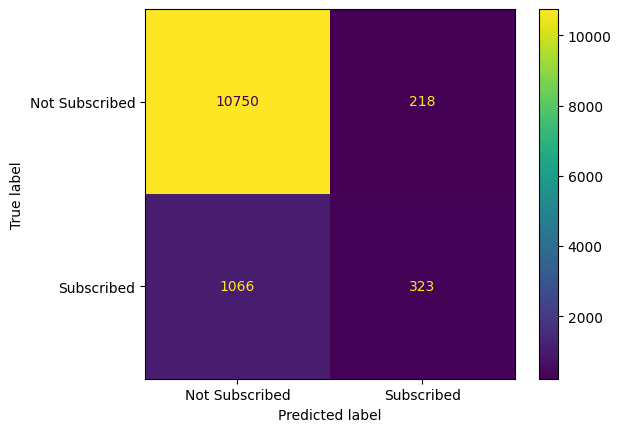

,Scores,Values
0,Precision,0.597043
1,Recall,0.232541
2,Accuracy,0.896091
3,F1,0.334715


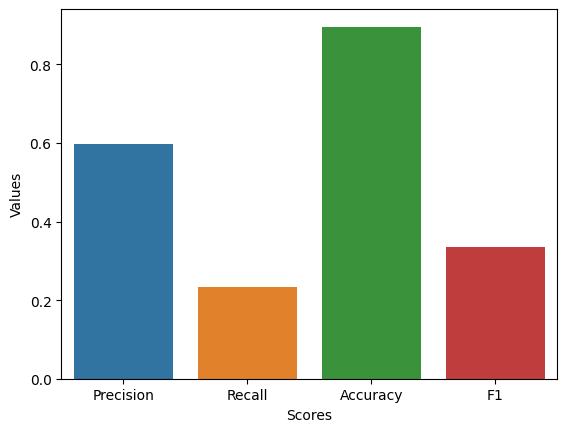

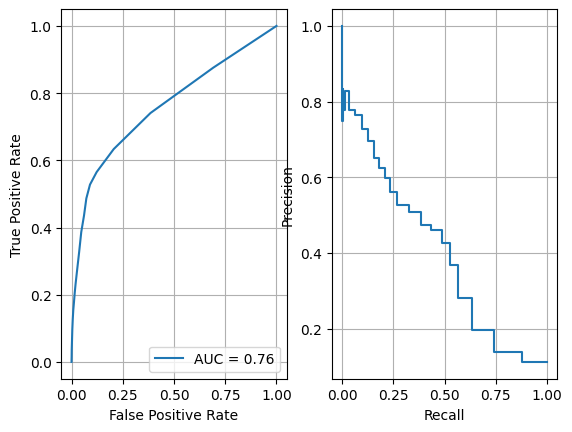

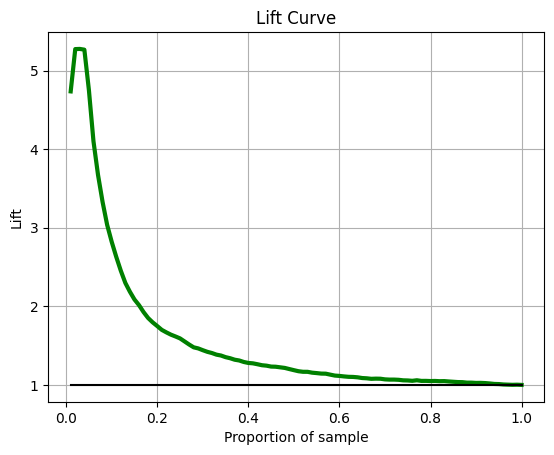

In [68]:
# Predict and score the best estimator performance
y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)
getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Subscribed', 'Subscribed'])
precision, recall, accuracy, f1 = getScores(y_test, y_test_pred)
getCurves(X_test, best_est)

In [69]:
# Save result to list
save_result_2('KNN', fit_time, accuracy, f1, recall, precision)
results_list2[0]

{'Model': 'KNN',
 'Train Time': 10.10500693321228,
 'Accuracy': 0.896091284292304,
 'f1': 0.33471502590673574,
 'recall': 0.23254139668826493,
 'precision': 0.5970425138632163}

#### Logistic Regression Grid Search Execution

In [70]:
# Pipeline with model, feature encoding and scaling
lr_pipe = Pipeline([
        ('tranform', column_transf),
        ('stdscl', StandardScaler()),
        ('model', LogisticRegression(penalty = 'l1', solver = 'liblinear', random_state=42, max_iter = 1000))
    ])

lr_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('stdscl', StandardScaler()),
                ('model',
                 LogisticRegression(max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

In [71]:
# Run Gridsearch and get the best estimator
params = {'model__C': [0.01, 0.1, 1, 10],
          'model__penalty': ['l1', 'l2'], 'model__solver': ['liblinear', 'saga'], 
          'model__random_state':[42], 'model__max_iter': [100, 1000, 2500]}
grid = GridSearchCV(lr_pipe, param_grid=params).fit(X_train, y_train)
best_est = grid.best_estimator_
best_est.fit(X_train, y_train)

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('stdscl', StandardScaler()),
                ('model',
                 LogisticRegression(C=0.01, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [72]:
grid.best_params_

{'model__C': 0.01,
 'model__max_iter': 100,
 'model__penalty': 'l1',
 'model__random_state': 42,
 'model__solver': 'liblinear'}

In [73]:
# Get the fit time from grid cvresults_
fit_time = get_training_time_from_grid(grid)
fit_time

47.23866391181945

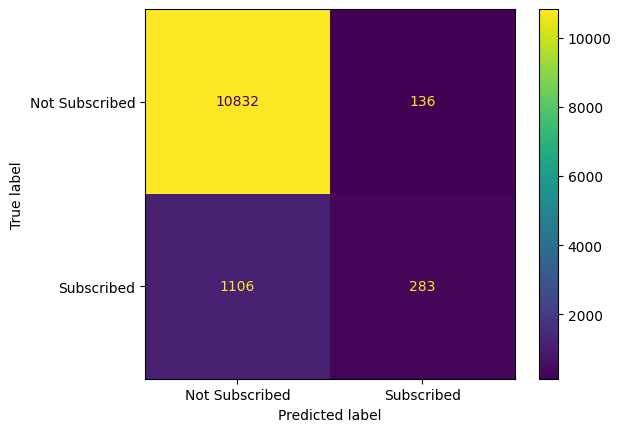

,Scores,Values
0,Precision,0.675418
1,Recall,0.203744
2,Accuracy,0.899490
3,F1,0.313053


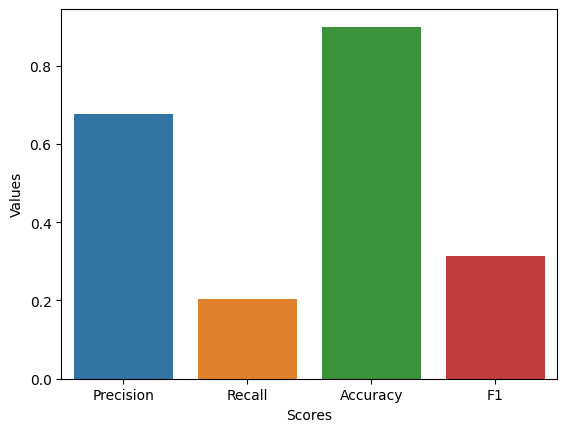

In [74]:
# Predict and get the score performance of the best estimator
y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)
getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Subscribed', 'Subscribed'])
precision, recall, accuracy, f1 = getScores(y_test, y_test_pred)

In [75]:
# Save result to list
save_result_2('LogisticRegression', fit_time, accuracy, f1, recall, precision)
results_list2[1]

{'Model': 'LogisticRegression',
 'Train Time': 47.23866391181945,
 'Accuracy': 0.8994901675163874,
 'f1': 0.31305309734513276,
 'recall': 0.20374370050395968,
 'precision': 0.6754176610978521}

#### Decision Tree Grid Search Execution

In [76]:
# Pipeline with model, feature encoding and scaling
t_pipe = Pipeline([
        ('tranform', column_transf),
        ('stdscl', StandardScaler()),
        ('model', DecisionTreeClassifier(random_state=42))
    ])

t_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('stdscl', StandardScaler()),
                ('model', DecisionTreeClassifier(random_state=42))])

In [77]:
# Run Gridsearch and get the best estimator
params = {'model__max_depth': [1,2,3,4,5,6,7,8],
         'model__min_samples_split': [2,4,6,8],
          'model__criterion': ['gini', 'entropy'],
          'model__min_samples_leaf': [1,2,4,6]
         }

grid = GridSearchCV(t_pipe, param_grid=params).fit(X_train, y_train)
best_est = grid.best_estimator_
best_est.fit(X_train, y_train)

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('stdscl', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        min_samples_leaf=6, random_state=42))])

In [78]:
grid.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': 5,
 'model__min_samples_leaf': 6,
 'model__min_samples_split': 2}

In [79]:
# Get the fit time from grid cvresults_
fit_time = get_training_time_from_grid(grid)
fit_time

162.90356040000916

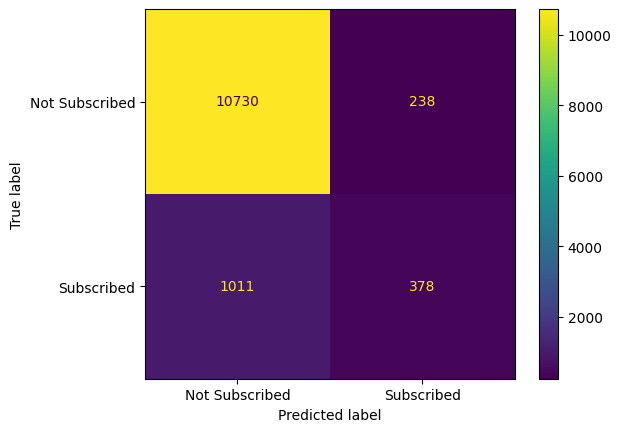

,Scores,Values
0,Precision,0.613636
1,Recall,0.272138
2,Accuracy,0.898924
3,F1,0.377057


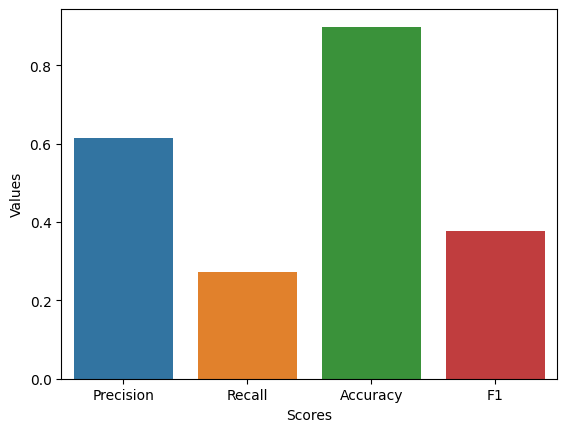

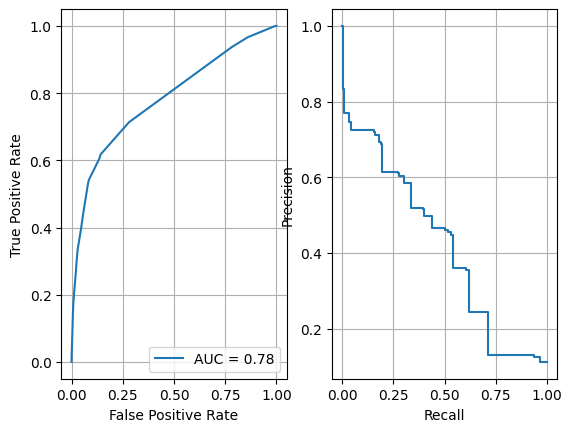

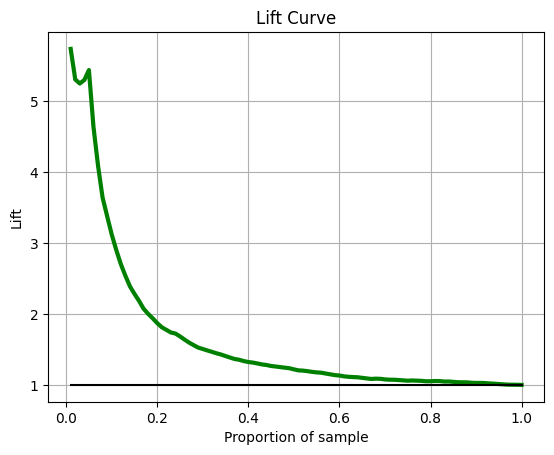

In [80]:
# Predict and score the performance of the best estimator
y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)
getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Subscribed', 'Subscribed'])
precision, recall, accuracy, f1 = getScores(y_test, y_test_pred)
getCurves(X_test, best_est)

In [81]:
# Save result to list
save_result_2('DecisionTree', fit_time, accuracy, f1, recall, precision)
results_list2[2]

{'Model': 'DecisionTree',
 'Train Time': 162.90356040000916,
 'Accuracy': 0.8989236869790402,
 'f1': 0.37705735660847883,
 'recall': 0.27213822894168466,
 'precision': 0.6136363636363636}

#### SVM Grid Search Execution

In [82]:
# Pipeline with model, feature encoding and scaling
svr_pipe = Pipeline([
        ('tranform', column_transf),
        ('stdscl', StandardScaler()),
        ('model', SVC())
    ])

svr_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('stdscl', StandardScaler()), ('model', SVC())])

In [ ]:
# Run Gridsearch and get the best estimator
#params = {'model__kernel': ('linear', 'poly', 'rbf', 'sigmoid'),'model__degree' : [2,3,4,5], 'model__gamma': [0.01, 0.1],
#         'model__probability':[True]}
params = {'model__kernel': ('linear', 'poly'),'model__degree' : [2,3,4,5], 'model__gamma': [0.01, 0.1],
         'model__probability':[True]}
grid = HalvingRandomSearchCV(svr_pipe, param_distributions=params, scoring = 'f1').fit(X_train, y_train)
best_est = grid.best_estimator_
best_est.fit(X_train, y_train)

In [85]:
grid.best_params_

{'model__probability': True,
 'model__kernel': 'linear',
 'model__gamma': 0.1,
 'model__degree': 5}

In [87]:
# Get the fit time from grid cvresults_
fit_time = get_training_time_from_grid(grid)
fit_time

2.2846603393554688

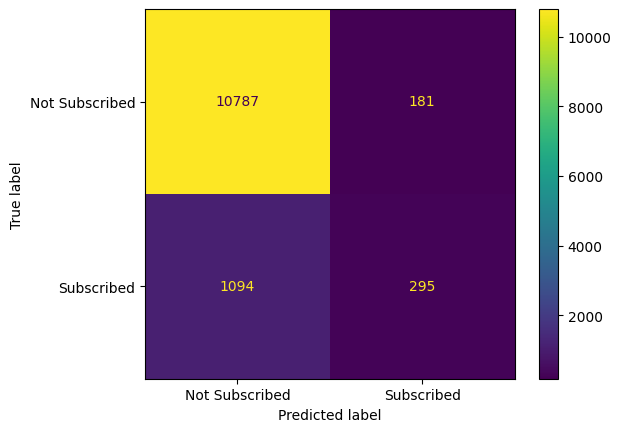

,Scores,Values
0,Precision,0.619748
1,Recall,0.212383
2,Accuracy,0.896820
3,F1,0.316354


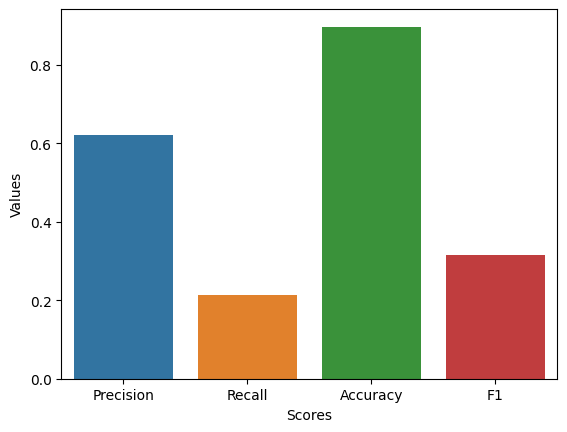

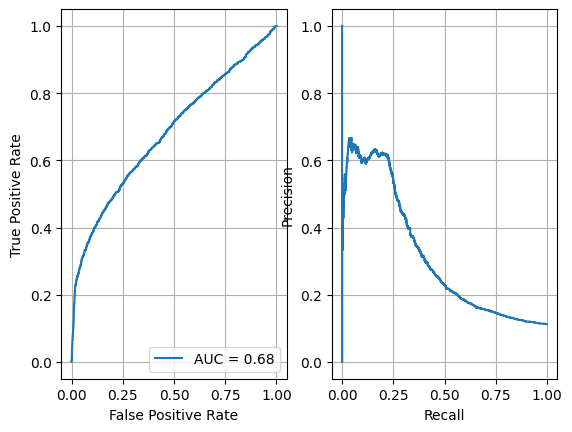

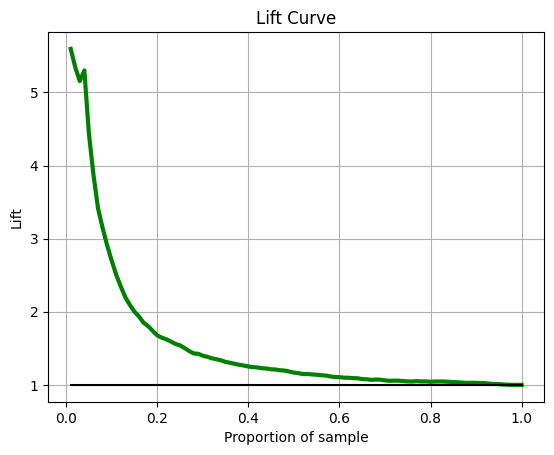

In [88]:
# Predict and score the performance of the best estimator
y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)
getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Subscribed', 'Subscribed'])
precision, recall, accuracy, f1 = getScores(y_test, y_test_pred)
getCurves(X_test, best_est)

In [ ]:
# Save result to list
save_result_2('SVM', fit_time, accuracy, f1, recall, precision)
results_list2[3]

{'Model': 'SVM',
 'Train Time': 2.2846603393554688,
 'Accuracy': 0.8968196164117505,
 'f1': 0.3163538873994638,
 'recall': 0.21238300935925125,
 'precision': 0.6197478991596639}

#### Review the GridSearch results for Improved models and data

In [94]:
# Get the result list as a dataframe
improved_results_df = pd.DataFrame(results_list2).sort_values(by='recall', ascending=False).set_index('Model')  
improved_results_df

,Train Time,Accuracy,f1,recall,precision
Model,,,,,
DecisionTree,162.903560,0.898924,0.377057,0.272138,0.613636
KNN,10.105007,0.896091,0.334715,0.232541,0.597043
SVM,2.284660,0.896820,0.316354,0.212383,0.619748
LogisticRegression,47.238664,0.899490,0.313053,0.203744,0.675418


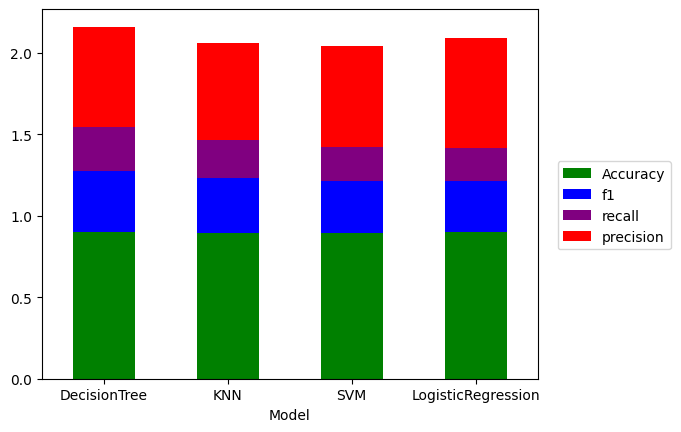

In [107]:
bar_colors = ['green', 'blue', 'purple', 'red']
improved_results_df.drop('Train Time', axis = 1).plot(kind='bar', stacked=True, color=bar_colors)
plt.xticks(rotation=0)
plt.legend(loc=(1.04, 0.35))
plt.show()

- These results show us the Decision Tree has the better Recall and f1, also the its accuracy and score are the best too.
- Next, we use that model to identify the most important features

#### Run the Permutation importance for Decision Tree with the best params.

In [71]:
# Create the pipeline for DecisionTree with the best params gotten from the GridSearch
decisiontree_pipe = Pipeline([
        ('tranform', column_transf),
        ('stdscl', StandardScaler()),
        ('model', DecisionTreeClassifier(criterion='entropy', 
                                         max_depth=5, 
                                         min_samples_leaf=6, 
                                         min_samples_split=2, 
                                         random_state=42))
    ])

decisiontree_pipe.fit(X_train, y_train)


Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('stdscl', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        min_samples_leaf=6, random_state=42))])

In [72]:
# Run permutation 
importances = permutation_importance(decisiontree_pipe, X_train, y_train, n_repeats = 10, random_state=40)

In [73]:
# Get the features
importances_tr = dict(zip(X_train.columns, importances.importances_mean))
#display(importances_tr)
importances_tr = {k : v for k ,v in sorted(importances_tr.items(), key = lambda x: x[1], reverse = True)}
#display(importances_tr)
import_df = pd.DataFrame(importances_tr.values(), index=importances_tr.keys(), columns = ['Importances'])
display(import_df)


,Importances
euribor3m,0.054223
month,0.022254
pdays,0.014002
cons.conf.idx,0.007901
poutcome,0.003975
contact,0.003458
campaign,0.001717
day_of_week,0.000430
marital,0.000395
age,0.000243


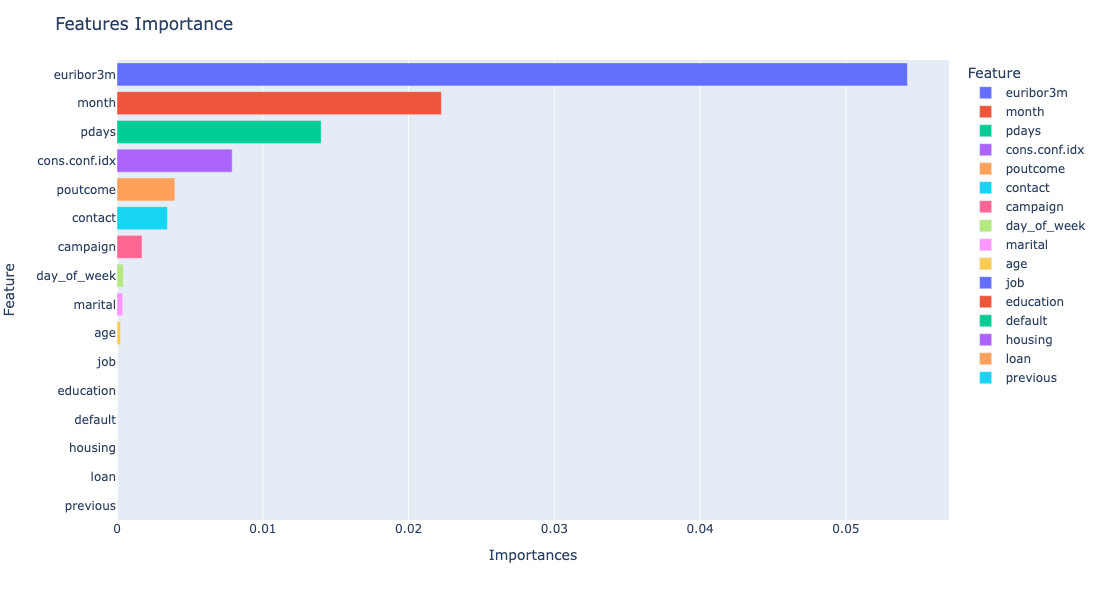

In [75]:
fig = px.bar(import_df.reset_index(), x="Importances", y = 'index', color='index', labels={'index' : 'Feature'})
fig.update_layout(
    autosize=False,
    width=750,
    height=600,
    title="Features Importance"
)
fig.show()

#### Review the Top 3 features impacting on the Prediction

#### Euribor3m
Euribor 3 month rate - daily indicator

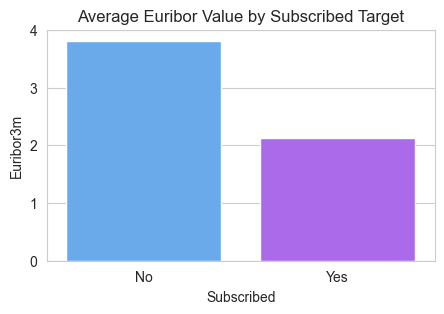

In [167]:
# Plot the Euribor3m proportion
plot_data = df.groupby('subscribed')['euribor3m'].mean().reset_index()
plot_data = plot_data.sort_values(by='euribor3m', ascending=False)
plot_data['subscribed'] = np.where(plot_data['subscribed'] == 1 , 'Yes', 'No')

plt.figure(figsize=(5, 3))  
sns.barplot(data=plot_data, x='subscribed', y='euribor3m', palette = 'cool')
plt.title('Average Euribor Value by Subscribed Target')
plt.xlabel('Subscribed')
plt.ylabel('Euribor3m')
plt.show()


- Euribor has an important influence on the prediction of whether or not a client accepts to subscribe to a bank account. 
- We can see the average Euribor is higher in customers who did not accept the deposit while in customers who accepted the deposit the Euribor is lower, so we can conclude that when the Euribor has a low value it's the best time to promote the Bank term deposit product.

#### Month
Last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

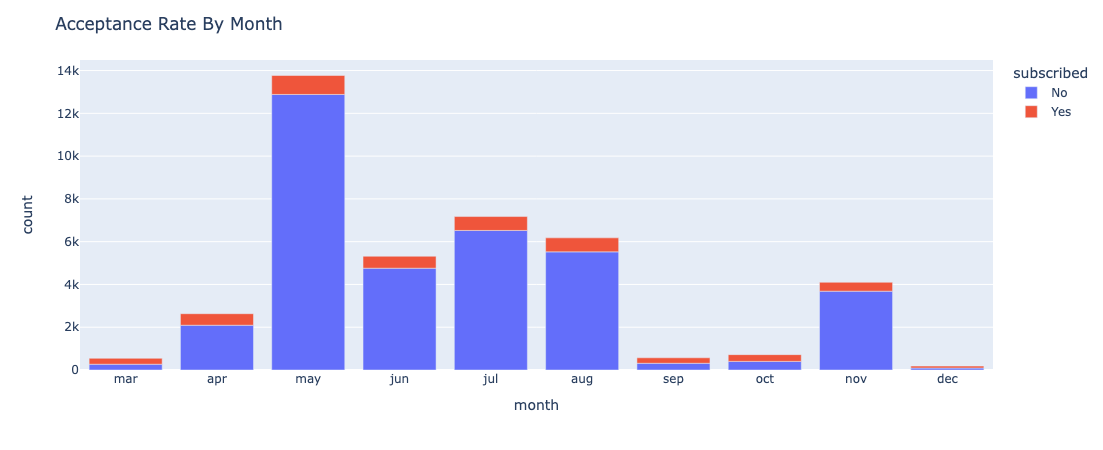

In [190]:
plot_data = df.groupby('month')['subscribed'].value_counts().reset_index()
# Add the numeric column for month so we can order data propertly
num_months = {'jan': 1, 'feb': 2,'mar': 3, 'apr': 4, 'may': 5, 'jun':6, 'jul': 7, 'aug': 8,'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
plot_data['month_num'] = plot_data['month'].replace(num_months)

plot_data = plot_data.sort_values(by='month_num', ascending=True)
plot_data['subscribed'] = np.where(plot_data['subscribed'] == 1 , 'Yes', 'No')

fig = px.bar(plot_data, x='month', y='count', color='subscribed')
fig.update_layout(autosize=False, width=800, height=450, title="Acceptance Rate By Month")
fig.show()

- The month has important impact on subscription acceptance, we can see May, June, Jul, August have high rejection.
- It's important to review the reasons of the rejection so the Bank can focus the campaing better, e.g: maybe customers are concerned to spend their money on vacations, kids education, Christmas gifts. 

#### pdays
Number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

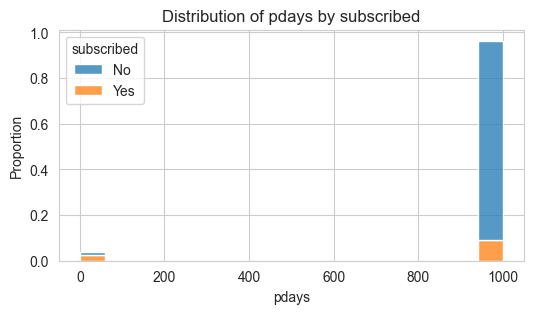

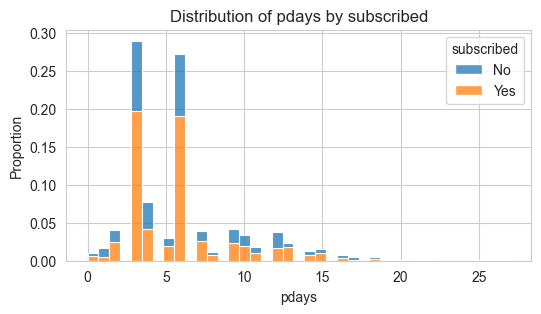

In [214]:
plot_data = df[['subscribed', 'pdays']].copy()
plot_data['subscribed'].replace({1: 'Yes', 0: 'No'}, inplace=True) 

plt.figure(figsize = (6, 3))
sns.histplot(data = plot_data, x = "pdays", hue = "subscribed", 
             multiple = "stack", stat = "proportion").set(title = "Distribution of pdays by subscribed")
plt.show()

plt.figure(figsize = (6, 3))
sns.histplot(data = plot_data[plot_data["pdays"] != 999], x = "pdays", hue = "subscribed", 
             multiple = "stack", stat = "proportion").set(title = "Distribution of pdays by subscribed")
plt.show()

- Clients that have not been previously contacted largely do not subscribe, while the majority of clients that have been previously contacted subscribed.
- The majority of clients last contacted 6, 3, and 4 days prior were subscribers.

### Findings

1. During this practical application we applied two approaches: one is the basic, with fewer features(bank client data) and simple models, this gave us an initial idea of the data behavior vs the target feature. Then we included more features, after a data correlation analysis we could discard some of them and by the dataset's documentation we removed others which did not make sense to have them in the analysis. This process was valuable because we were getting important insights about the data and about the objetive of the project.
2. By Using different Classification algorithms (KNN, Logistic Regression, Decision Tree and SVM) and comparing their performance results we got the best one for this particular dataset is Decision Tree, it got the best Recall and F1 score which are aligned to the objective to correctly identify the most of the subscribers (minimizing false negatives).  
3. The execution time and training time are factors which could impact on the decision to choose a Classification algorithm but we need to find a balance between those times and the scores we could get from the differents models. CRISP-DM allows to iteratively improve our data and the parameters to get the best performances.
4. Identify the most important featuures is a key part in the understanding of the prediction, by analysing their data distribution and relation to the target feature (subscribed) we could determine why the customer took the decision to accept the bank term deposit, for example:
- Euribor3m (Euribor 3 month rate - daily indicator)
- Month (Last contact month of year)
- Pdays (Number of days that passed by after the client was last contacted from a previous campaign)

### Next Steps and Recomendations

1. Improve the Classification process by adding tools to handle the imbalanced dataset, as we can see, this dataset is imbalanced which yields some metrics can be misleading between them. One improvement we could do in this process the Resampling Techniques:
- Oversampling: Duplicate samples from the minority class to increase its representation.
- Undersampling: Remove samples from the majority class to balance the dataset.
- SMOTE (Synthetic Minority Oversampling Technique): Generates synthetic data points for the minority class.

2. Analyse the the other features, for the scope of this project, we reviewed the top 3 features, the others need to be analyzed to get more valuable information.